In [1]:
%reload_ext autoreload
%autoreload 1
import torch 
import sys
sys.path.append('..')
from torch import nn 
from torch.nn import functional as F
from torch import optim
from utils.metrics import compute_nb_errors
from utils.plot import learning_curve
from utils.new_loader import load
from utils.new_loader import PairSetMNIST, Test_set, Training_set, Training_set_split, Validation_set
from torch.utils.data import Dataset, DataLoader

In [2]:
# Auxiliary Network Architectures 

class conv_block(nn.Module) :
    """
    basic 2d convolution with batch norm
    """
    
    def __init__(self, in_channels,out_channels,kernel_size = 1,stride =1, padding = 0) :
        super(conv_block,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride ,padding)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self,x) :
        x = self.bn(self.conv(x))
        return x

class Inception_block(nn.Module):
    """
    Inception block with four different filters scale
    """
    def __init__(self,in_channels,channels_1x1,channels_3x3,channels_5x5,pool_channels):
        super(Inception_block, self).__init__()
        # 1x1 convolution
        self.conv1x1 = conv_block(in_channels,channels_1x1, kernel_size = 1)
        # 3x3 convolution factorized in 1x3 followed by 3x1
        self.conv3x3 = nn.Sequential(conv_block(in_channels,channels_3x3, kernel_size = 1),
                                     conv_block(channels_3x3, channels_3x3, kernel_size = (1,3), padding = (0,1)),
                                     conv_block(channels_3x3, channels_3x3, kernel_size = (3,1), padding = (1,0)))
        # 5x5 convolution factorized in two consecutive 3x3 implemented as above
        self.conv5x5 = nn.Sequential(conv_block(in_channels,channels_5x5, kernel_size = 1),
                                     conv_block(channels_5x5, channels_5x5, kernel_size = (1,3),padding =(0,1)),
                                     conv_block(channels_5x5, channels_5x5, kernel_size = (3,1), padding = (1,0)),
                                     conv_block(channels_5x5,channels_5x5, kernel_size = (1,3),padding=(0,1)),
                                     conv_block(channels_5x5, channels_5x5, kernel_size = (3,1),padding = (1,0)))
        # pooling layer 
        self.pool = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
                                  conv_block(in_channels, pool_channels, kernel_size=1))

        
    def forward(self, x):
        
        # compute the four filter of the inception block :  Nx64x14x14
        scale1 = F.relu(self.conv1x1(x))
        scale2 = F.relu(self.conv3x3(x))
        scale3 = F.relu(self.conv5x5(x))
        scale4 = F.relu(self.pool(x))
        
        # concatenate layer for next result
        outputs = [scale1, scale2, scale3, scale4]
        # Nx256x14x14
        filter_cat = torch.cat(outputs,1)
        
        return filter_cat


class Auxiliary_loss (nn.Module) :
    """
    auxiliary loss classification of the digit
    """
    
    def __init__(self,in_channels,drop_prob_aux,nb_classes = 10):
        super(Auxiliary_loss, self).__init__()
        
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, nb_classes)
        self.dropout= nn.Dropout(drop_prob_aux)

    def forward(self, x):
        # aux: N x 256 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux: N x 256 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = x.view(-1,2048)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = self.dropout(x)
        # N x 10 (nb_classes)
        x = self.fc2(x)

        return x

class Google_Net (nn.Module) :
    """
    Google net implementing two inception layer in parralel for each channel
    Use auxiliary loss to classify the digit number
    Concatenate the number classification feature map and classify the two channel
    """
    
    def __init__(self,channels_1x1,channels_3x3,channels_5x5,pool_channels,nhidden = 60,
                 drop_prob = 0,drop_prob_aux = 0.7,nb_classes = 10):
        super(Google_Net, self).__init__()
        
        # local response norm
        self.conv1 = conv_block(1, 32, kernel_size = 3, padding = (3 - 1)//2)
        #inception block
        self.inception1 = Inception_block(1,channels_1x1,channels_3x3,channels_5x5,pool_channels)
        self.inception2 = Inception_block(256,channels_1x1,channels_3x3,channels_5x5,pool_channels)
        #auxiliary
        self.auxiliary = Auxiliary_loss(256,drop_prob_aux)
        
        # weights for binary classification 
        self.fc1 = nn.Linear(20, nhidden)
        self.fc2 = nn.Linear(nhidden, 90)
        self.fc3 = nn.Linear(90, 2)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, input_):
        
        # split the 2-channel input into two 1*14*14 images
        x = input_[:, 0, :, :].view(-1, 1, 14, 14)
        y = input_[:, 1, :, :].view(-1, 1, 14, 14)
        
        # Local response norm
        #x = self.conv1(x)
        #y = self.conv1(y)
        
        # inception blocks
        x = self.inception1(x)
        y = self.inception1(y)
        
        
        # auxiliary loss 
        x = self.auxiliary(x)
        y = self.auxiliary(y)
        
        # concatenate layers  
        z = torch.cat([x, y], 1)
        
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = self.dropout(z)
        z = self.fc3(z)
        
        
        return x,y,z

In [5]:
# metrics calculator function 

def compute_metrics(model, test_data, mini_batch_size=100, criterion=nn.CrossEntropyLoss()):
    """
    function to calculate prediction accuracy + loss of a cnn with auxiliary loss

    """
    # generate data loader from test data
    test_loader = DataLoader(test_data, batch_size=mini_batch_size, shuffle=False)
    # evaluation mode
    model.eval()
    test_loss = 0
    nb_errors = 0
    # inactivate autograd 
    with torch.no_grad():

        # mini batch loop
        for i, data in enumerate(test_loader, 0):

            input_, target_, classes_ = data
            _, _, output = model(input_) 
            batch_loss = criterion(output, target_)
            test_loss += batch_loss     
            nb_errors += compute_nb_errors(output, target_)
        
        # compute accuracy and loss over all minibatches 
        acc = 100*(1 - (nb_errors/test_data.len) )
        test_loss = test_loss/test_data.len     

        return test_loss.item(), acc

####################################################################################################################

# train function 

def train_aux (model, train_data, validation_data, mini_batch_size=100, optimizer = optim.SGD,
                criterion = nn.CrossEntropyLoss(), n_epochs=50, eta=1e-1, lambda_l2 = 0, alpha=0.5, beta=0.5):
    
    
    """
    Train network with auxiliary loss + weight sharing
    
    """
    # define lists to record training history
    train_accuracies = []
    train_losses = []
    validation_accuracies = []
    validation_losses = []

    # train mode
    # model.train()
    # generate data loader from training set with random shuffling 
    train_loader = DataLoader(train_data, batch_size=mini_batch_size, shuffle=True)
    # define optimizer
    optimizer = optimizer(model.parameters(), lr = eta)

    # epochs loop
    for e in range(n_epochs):
        model.train()
        epoch_loss = 0
        
        # train mini-batch loop
        for i, data in enumerate(train_loader, 0):
            
            input_, target_, classes_ = data
            class_1, class_2,out = model(input_)
            aux_loss1 = criterion(class_1, classes_[:,0])
            aux_loss2 = criterion(class_2, classes_[:,1])
            out_loss  = criterion(out, target_)
            net_loss = (alpha * (out_loss) + beta * (aux_loss1 + aux_loss2 ))
            epoch_loss += net_loss

            # optional L2 penalty term to the loss 
            if lambda_l2 != 0:
                for p in model.parameters():
                    epoch_loss += lambda_l2 * p.pow(2).sum() 
            
            # gradient step 
            optimizer.zero_grad()
            net_loss.backward()
            optimizer.step()

            print(epoch_loss.item())
        
        print('Train Epoch: {}  | Loss {:.6f}'.format(
                e, epoch_loss.item()))

        # epoch validation step
        tr_loss, tr_acc = compute_metrics(model, train_data)
        val_loss, val_acc = compute_metrics(model, validation_data)
        train_accuracies.append(tr_acc)
        train_losses.append(tr_loss)
        validation_accuracies.append(val_acc)
        validation_losses.append(val_loss)

    return train_losses, train_accuracies, validation_losses, validation_accuracies
        
####################################################################################################################

# simple model validation

def validate_model(model, mini_batch_size=100, optimizer = optim.SGD,
                 criterion = nn.CrossEntropyLoss(), n_epochs=40, eta=1e-1, 
                 lambda_l2 = 0, alpha=0.5, beta=0.5, plot=True): 

    """ Training / validation over n_epochs + testing a full test set"""
    
    # load the Data
    datasetMNIST = PairSetMNIST(swap_channel=False)
    training_data = Training_set(datasetMNIST)
    test_set = Test_set(datasetMNIST) # test set
    training_set = Training_set_split(training_data) # training set
    validation_set = Validation_set(training_data) # validation set
    
    # train and store training history
    train_losses, train_acc, valid_losses, valid_acc = train_aux(model, training_set, validation_set, mini_batch_size,optimizer, criterion, n_epochs, eta, lambda_l2, alpha, beta)
    
    if plot:
        
        learning_curve(train_losses, train_acc, valid_losses, valid_acc)

    # final test on full test set
    test_loss, test_accuracy = compute_metrics(model, test_set)
    
    print('\nTest Set | Loss: {:.4f} | Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))
    


2.706146240234375
5.141275405883789
7.686578750610352
10.067659378051758
12.351702690124512
14.530265808105469
16.58197593688965
18.403772354125977
Train Epoch: 0  | Loss 18.403772
1.6766910552978516
3.085376739501953
4.401853561401367
5.641093730926514
6.822383880615234
7.913666725158691
9.016768455505371
10.03943920135498
Train Epoch: 1  | Loss 10.039439
1.160021424293518
2.1145079135894775
3.223240852355957
4.361953258514404
5.361552715301514
6.322635173797607
7.2991943359375
8.577874183654785
Train Epoch: 2  | Loss 8.577874
1.4416621923446655
2.256976366043091
3.0853898525238037
3.8356504440307617
4.443648338317871
5.145674705505371
5.698300361633301
6.2356085777282715
Train Epoch: 3  | Loss 6.235609
0.6308530569076538
1.223515272140503
1.8218961954116821
2.686464309692383
3.452737808227539
4.1024088859558105
4.624025344848633
5.172311782836914
Train Epoch: 4  | Loss 5.172312
0.5390072464942932
1.0279899835586548
1.4859846830368042
1.8910900354385376
2.3139193058013916
2.8053457736

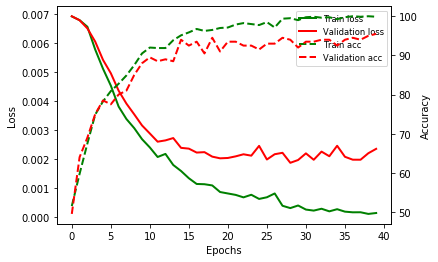

NameError: name 'test_data' is not defined

In [6]:
Gnet = Google_Net(64,64,64,64)
validate_model(Gnet)